<a href="https://colab.research.google.com/github/MohsenSadeghi/ml_course/blob/main/notebooks/notebook_1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [2]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

cuda0 = torch.device('cuda:0')
cpu0 = torch.device('cpu:0')

Is CUDA available: True
CUDA version: 11.6
PyTorch version: 1.13.0+cu116
CUDA device name: Tesla T4


### We want to fit a polynomial to some data points. 

The parameter ```n_data_points``` controls the number of these points.<br/>
The parameter $\sigma$ (```noise_scale```) is the magnitude of inherent noise added to the $\overline{y}$ values.  

In [41]:
n_data_points = 100
n_validation_points = 20
noise_scale = 2.0

validation_points_indices = np.random.randint(0, n_data_points - 1, n_validation_points)
mask = np.zeros(n_data_points, dtype=bool)
mask[validation_points_indices] = True
mask = torch.tensor(mask)

x = torch.linspace(0.0, 2.0, n_data_points, device=cuda0)

x_training = x[torch.logical_not(mask)]
x_validation = x[mask]

print(len(x_training), len(x_validation))

81 19


### This is the target function that we use to generate $\left(\overline{x}_i, \overline{y}_i\right)$ pairs as $\overline{y}_i=f\left(\overline{x}_i\right) + \epsilon$ where $\epsilon\sim\mathcal{N}\left(0, \sigma^2\right)$.

In [42]:
def target_function (x):

    return 10.0 * torch.cos (np.pi * x - 0.3 * np.pi)

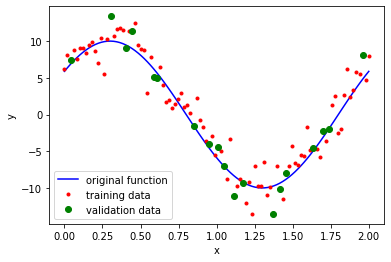

In [43]:
y_true = target_function (x)

y_observed = target_function(x) + torch.normal (size=(n_data_points, ),
                                                mean=0.0, std=noise_scale, device=cuda0)

y_training = y_observed[torch.logical_not(mask)]
y_validation = y_observed[mask]

plt.figure ()
plt.plot(x.to(cpu0), y_true.to(cpu0), 'b-', label="original function")
plt.plot(x_training.to(cpu0), y_training.to(cpu0), 'r.', label="training data")
plt.plot(x_validation.to(cpu0), y_validation.to(cpu0), 'go', label="validation data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

### This is our parametrized model

which in this case is simply a polynomial of arbitrary degree (length of ```params``` determines the polynomial degree). 

In [44]:
def model(params, x):

    result = torch.tensor([0.0], device=cuda0, requires_grad=True)
    exponent = torch.tensor([0], device=cuda0)

    for i, _p in enumerate(params):
        result = result + _p * torch.pow(x, exponent)
        exponent = exponent + 1

    return result

### This is the Loss function

which simply is the mean squared error (MSE) between true and predicted values of the function.

In [45]:
def loss_function (params, x, y_true):

    y_predicted = model (params, x)

    loss = torch.mean((y_predicted - y_true) ** 2)

    return loss

In [46]:
params = torch.tensor([1.0, -1.0], device=cuda0, requires_grad=True)

print(loss_function(params, x_validation, y_validation))

tensor(60.4315, device='cuda:0', grad_fn=<MeanBackward0>)


### The PyTorch autograd functionality can track our loss function and find its gradients with respect to the model parameters

In [47]:
gradients = torch.autograd.grad(outputs=loss_function(params, x_training, y_training), inputs=params)
print(gradients)

(tensor([-1.8701,  2.3854], device='cuda:0'),)


### The same functionality is achieved with the ```loss.backward()``` command:

In [48]:
if params.grad is not None:
    params.grad.data.zero_()

loss = loss_function(params, x_training, y_training)

loss.backward()

print(params.grad)

tensor([-1.8701,  2.3854], device='cuda:0')


### Getting things ready for the training loop

The list ```p0``` is the initial value of the trainable parameters of the model. You can change the number of elements in ```p0``` to change the order of the polynomial being used by the model. 

In [51]:
deg = 4

p0 = np.zeros(deg)

params = torch.tensor(p0, device=cuda0, requires_grad=True)
learning_rate = torch.tensor([1.0e-2], device=cuda0)
batch_size = 16

gathered_loss = {'training': [], 'validation':[]}

In [52]:
for i in range(1000):

    for batch_x_training, batch_y_trainig in zip(torch.split(x_training, batch_size),
                                                 torch.split(y_training, batch_size)):

        if params.grad is not None:
            params.grad.data.zero_()
            
        loss = loss_function(params, x_training, y_training)
        loss.backward ()

        params.data = params.data - learning_rate * params.grad.data

    training_loss = loss_function(params, x_training, y_training).item()
    validation_loss = loss_function(params, x_validation, y_validation).item()
    
    gathered_loss['training'].append(training_loss)
    gathered_loss['validation'].append(validation_loss)
    
    if i % 100 == 0:
        print(f"epoch: {i} --- current training loss value = {training_loss: .3f} --- current validation loss value = {validation_loss: .3f} ")

epoch: 0 --- current training loss value =  50.372 --- current validation loss value =  61.467 
epoch: 100 --- current training loss value =  19.532 --- current validation loss value =  28.792 
epoch: 200 --- current training loss value =  12.277 --- current validation loss value =  17.968 
epoch: 300 --- current training loss value =  10.392 --- current validation loss value =  14.067 
epoch: 400 --- current training loss value =  9.816 --- current validation loss value =  12.429 
epoch: 500 --- current training loss value =  9.562 --- current validation loss value =  11.628 
epoch: 600 --- current training loss value =  9.390 --- current validation loss value =  11.174 
epoch: 700 --- current training loss value =  9.241 --- current validation loss value =  10.876 
epoch: 800 --- current training loss value =  9.102 --- current validation loss value =  10.653 
epoch: 900 --- current training loss value =  8.969 --- current validation loss value =  10.469 


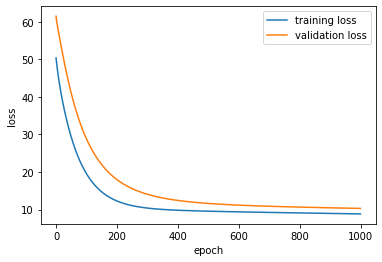

In [53]:
plt.figure()

for loss_type in ['training', 'validation']:
    
    _loss = gathered_loss[loss_type]
    
    plt.plot(np.arange(len(_loss)), _loss, label=loss_type + ' loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [54]:
def display_prediction (params):
    y_predicted = model(params.data, x).clone().detach()

    plt.figure ()
    plt.plot(x.to(cpu0), y_true.to(cpu0), 'b-', label="original function")
    plt.plot(x.to(cpu0), y_observed.to(cpu0), 'r.', label="observed data")
    plt.plot(x.to(cpu0), y_predicted.to(cpu0), 'g-', label="predicted function")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

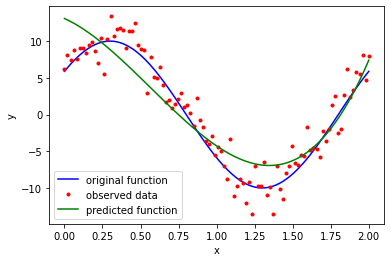

In [55]:
display_prediction (params)